In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install scikit-dsp-comm

     |████████████████████████████████| 90 kB 4.4 MB/s 


In [3]:
import numpy as np
import numpy.matlib
import pandas as pd
import xlrd
import os
import librosa
import librosa.display
from scipy import signal
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from scipy.signal import find_peaks
import sk_dsp_comm.sigsys as ss
import sk_dsp_comm.fir_design_helper as fir_d
import openpyxl
from openpyxl import Workbook
import math
import tensorflow as tf

Data for load recordings:

In [32]:
%cd /content/drive/MyDrive/final_project/segmentation/
data_table = xlrd.open_workbook('New Data For Syl Segmentation_3.xlsx').sheet_by_index(0)
mother = data_table.col_values(0, 1)
matgen = data_table.col_values(1, 1)
name = data_table.col_values(2, 1)
pupgen = data_table.col_values(4, 1)
age = data_table.col_values(5, 1)
session = data_table.col_values(6, 1)
rec_num = data_table.col_values(7, 1)

/content/drive/MyDrive/final_project/segmentation


In [33]:
#find path and load recordings:
SignalVec = []
sr = 250000
for i in range(len(mother)):
  path = '/content/drive/MyDrive/USV Recordings/2022/{}_{}/{}_{}/day_{}/session{}/{}.wav'.format(mother[i], matgen[i], name[i], pupgen[i], int(age[i]), int(session[i]), rec_num[i]) #find path of each recording
  if not os.path.exists('{}'.format(path)):
    path = '/content/drive/MyDrive/USV Recordings/2022/{}_{}/{}_{}/day_{}/session{}/{}.WAV'.format(mother[i], matgen[i], name[i], pupgen[i], int(age[i]), int(session[i]), rec_num[i])
    if not os.path.exists('{}'.format(path)):
      print(i)
      continue
  rec, rate = librosa.load(path, sr) #opens recordings and sample rate
  SignalVec.append(rec)

In [26]:
for i in range(len(mother)):
 SignalVec[i] = SignalVec[i]-np.mean(SignalVec[i]) #remove mean

 b_r = fir_d.fir_remez_lpf(100000,120000,0.5,40,250000) #lowpass FIR filter
 SignalVec[i] = lfilter(b_r, [1], SignalVec[i])

 b_rF = fir_d.fir_remez_bsf(48000,49500,50500,52000,0.5,40,250000) #filter noise in 50000 Hz 
 SignalVec[i] = lfilter(b_rF, [1], SignalVec[i])

 #b_rF = fir_d.fir_remez_bsf(56000,57500,58500,60000,0.5,40,250000) #filter noise in 60000 Hz 
 #SignalVec[i] = lfilter(b_rF, [1], SignalVec[i])

 #b_rF = fir_d.fir_remez_bsf(54000,55500,56500,58000,0.5,40,250000) #filter noise in 60000 Hz 
 #SignalVec[i] = lfilter(b_rF, [1], SignalVec[i])



Data of segmentation:

In [34]:
%cd /content/drive/MyDrive/final_project/segmentation/
data_table = xlrd.open_workbook('New Segmentatio Data For Final Class_3.xlsx').sheet_by_index(0)
motherSyl = data_table.col_values(1, 1)
nameSyl = data_table.col_values(3, 1)
ageSyl = data_table.col_values(6, 1)
sessionSyl = data_table.col_values(7, 1)
rec_numSyl = data_table.col_values(8, 1)
startSyl = data_table.col_values(9, 1)
endSyl = data_table.col_values(10, 1)

/content/drive/MyDrive/final_project/segmentation


Duration:

In [35]:
Duration = np.array(endSyl) - np.array(startSyl)

y = 2
workbook = openpyxl.load_workbook('/content/drive/MyDrive/final_project/segmentation/New Segmentatio Data For Final Class_3.xlsx')
worksheet = workbook.worksheets[0]
worksheet.insert_cols(12)
cell_title1 = worksheet.cell(row=1, column=12)
cell_title1.value = 'Duration (time)'
for x in range(len(Duration)):
    cell_to_write = worksheet.cell(row=y, column=12)
    cell_to_write.value = Duration[x]
    y += 1
workbook.save('/content/drive/MyDrive/final_project/segmentation/New Segmentatio Data For Final Class_3.xlsx')

ISI_time:

In [36]:
ISI = []
for i in range(len(rec_numSyl)):
  if rec_numSyl[i] == rec_numSyl[i-1]:
    ISI.append(startSyl[i] - endSyl[i-1])
  else:
    ISI.append(np.NaN)

y = 2
workbook = openpyxl.load_workbook('/content/drive/MyDrive/final_project/segmentation/New Segmentatio Data For Final Class_3.xlsx')
worksheet = workbook.worksheets[0]
worksheet.insert_cols(13)
cell_title1 = worksheet.cell(row=1, column=13)
cell_title1.value = 'ISI_time'
for x in range(len(ISI)):
    cell_to_write = worksheet.cell(row=y, column=13)
    cell_to_write.value = ISI[x]
    y += 1
workbook.save('/content/drive/MyDrive/final_project/segmentation/New Segmentatio Data For Final Class_3.xlsx')

Start End frequency:

In [37]:
siz = len(SignalVec)
StartEndFrec = []
#book = Workbook()
#sheet = book.active
#title = ['Mother','Name','Day','Session','Recording number','Start point(Hz)','End point(Hz)']
#sheet.append(title)
startF = []
endF = []
for s2 in range(siz):
  StartEndFrec = []
  for i in range(len(motherSyl)):
    if (mother[s2] == motherSyl[i]) and (name[s2] == nameSyl[i]) and (age[s2] == ageSyl[i]) and (session[s2] == sessionSyl[i]) and (rec_num[s2] == rec_numSyl[i]):
      st1 = round(startSyl[i]*rate)-1000
      if st1<0:
        st1 = 0
      f1, Pxx_den1 = signal.welch(SignalVec[s2][st1:st1+2000], rate, nperseg=1024, noverlap=625)
      st2 = round(endSyl[i]*rate)-1000
      f2, Pxx_den2 = signal.welch(SignalVec[s2][st2:st2+2000], rate, nperseg=1024, noverlap=625)
      k1 = np.where(f1>40000)
      peaksInd1, _ = find_peaks(Pxx_den1[k1[0][0]:-1])
      peaks1 = Pxx_den1[peaksInd1+k1[0][0]]
      is_empty = len(peaks1) == 0
      if (is_empty):
        StartEndFrec.append([0,0])
        startF.append(0)
        endF.append(0)
        continue
      peakMax1 = np.argmax(peaks1)
      frec1 = f1[peaksInd1[peakMax1]+k1[0][0]]
      k2 = np.where(f2>40000)
      peaksInd2, _ = find_peaks(Pxx_den2[k2[0][0]:-1])
      peaks2 = Pxx_den2[peaksInd2+k2[0][0]]
      peakMax2 = np.argmax(peaks2)
      frec2 = f2[peaksInd2[peakMax2]+k2[0][0]]
      #if frec2 == 58837.890625 or frec2 == 56396.484375:
       # peakMax2 = np.argsort(peaks2)[-2]
       # frec1 = f2[peaksInd2[peakMax2]+k2[0][0]]     
      StartEndFrec.append([f1[peaksInd1[peakMax1]+k1[0][0]],f2[peaksInd2[peakMax2]+k2[0][0]]])
      startF.append(f1[peaksInd1[peakMax1]+k1[0][0]])
      endF.append(f2[peaksInd2[peakMax2]+k2[0][0]])
  print(StartEndFrec)

y = 2
workbook = openpyxl.load_workbook('/content/drive/MyDrive/final_project/segmentation/New Segmentatio Data For Final Class_3.xlsx')
worksheet = workbook.worksheets[0]
worksheet.insert_cols(14,15)
cell_title1 = worksheet.cell(row=1, column=14)
cell_title1.value = 'Start Point (Hz)'
cell_title2 = worksheet.cell(row=1, column=15)
cell_title2.value = 'End Point (Hz)'
for x in range(len(startF)):
    cell_to_write = worksheet.cell(row=y, column=14)
    cell_to_write.value = startF[x]
    cell_to_write = worksheet.cell(row=y, column=15)
    cell_to_write.value = endF[x]
    y += 1
workbook.save('/content/drive/MyDrive/final_project/segmentation/New Segmentatio Data For Final Class_3.xlsx')

  #!/content/drive/MyDrive/final_project/segmentation
  #for i in range(len(StartEndFrec)):
   # new_row = [mother[s2],name[s2],age[s2],session[s2],rec_num[s2],StartEndFrec[i][0],StartEndFrec[i][1]]
   # sheet.append(new_row)
#book.save('Start End Frequency Syllable.xlsx')

[[69335.9375, 55175.78125], [69091.796875, 54443.359375], [71533.203125, 58837.890625], [58837.890625, 65917.96875], [88134.765625, 58837.890625], [70556.640625, 52734.375]]
[[67626.953125, 63720.703125]]
[[40527.34375, 41259.765625]]
[[58837.890625, 58837.890625], [58837.890625, 53466.796875], [58837.890625, 58837.890625], [58837.890625, 51269.53125], [69335.9375, 55175.78125]]
[[58837.890625, 82763.671875], [70556.640625, 54687.5], [58837.890625, 81542.96875], [68603.515625, 58837.890625], [55419.921875, 77392.578125], [65429.6875, 72753.90625], [58593.75, 77148.4375], [68603.515625, 68603.515625]]
[[58837.890625, 58837.890625], [70312.5, 58837.890625], [58837.890625, 75439.453125], [66162.109375, 77636.71875]]
[[64941.40625, 53222.65625], [58837.890625, 81787.109375], [66894.53125, 58837.890625], [66894.53125, 84960.9375], [58837.890625, 78125.0]]
[[58837.890625, 83740.234375], [70556.640625, 76660.15625], [58837.890625, 58837.890625], [71777.34375, 79345.703125], [65185.546875, 686

/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 1024 is greater than input length  = 1000, using nperseg = 1000
  .format(nperseg, input_length))


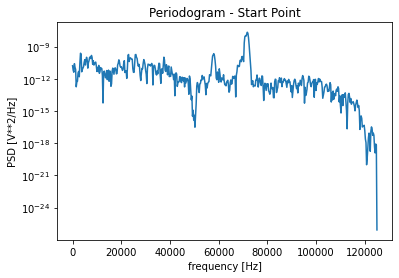

71750.0


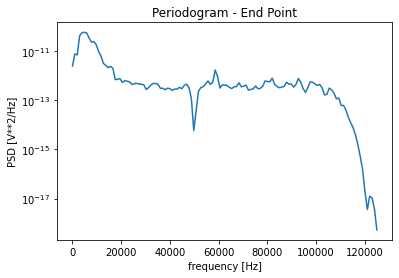

58593.75


In [ ]:
st = round(0.907202*rate)
f, Pxx_den = signal.welch(SignalVec[1][st:st+1000], rate, nperseg=1024, noverlap=625)
plt.semilogy(f, Pxx_den)
#plt.ylim([0.5e-3, 1])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('Periodogram - Start Point')
plt.show()
k = np.where(f>40000)
peaksInd, _ = find_peaks(Pxx_den[k[0][0]:-1])
peaks = Pxx_den[peaksInd+k[0][0]]
peakMax = np.argmax(peaks)
frec = f[peaksInd[peakMax]+k[0][0]]
#if frec == 58837.890625:
  #peakMax = np.argsort(peaks)[-2]
 # frec = f[peaksInd[peakMax]+k[0][0]]
print(frec)

st_end = round(0.598202*rate)-1000
f_end, Pxx_den_end = signal.welch(SignalVec[3][st_end:st_end+2000], rate)
plt.semilogy(f_end, Pxx_den_end)
#plt.ylim([0.5e-3, 1])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('Periodogram - End Point')
plt.show()
k_end = np.where(f_end>40000)
peaksInd_end, _ = find_peaks(Pxx_den_end[k_end[0][0]:-1])
peaks_end = Pxx_den_end[peaksInd_end+k_end[0][0]]
peakMax_end = np.argmax(peaks_end)
frec_end = f_end[peaksInd_end[peakMax_end]+k_end[0][0]]
#if frec == 58837.890625:
  #peakMax = np.argsort(peaks)[-2]
 # frec = f[peaksInd[peakMax]+k[0][0]]
print(frec_end)

In [ ]:
def closest_value(input_list, input_value):
 
  arr = np.asarray(input_list)
 
  i = (np.abs(arr - input_value)).argmin()
 
  return arr[i]

In [ ]:
import numpy
import pylab
import wave
import array

Fs = 250000
NFFT = int(Fs*0.005)  # 5ms window
noverlap = int(Fs*0.0025)
pylab.figure(figsize=(2,5))
spectrum, frec, t, im = pylab.specgram(SignalVec[0], NFFT=NFFT, Fs=Fs, noverlap=noverlap, cmap=pylab.get_cmap('Greys'))
pylab.title('A syllable spectrogram')
pylab.xlabel('Time [sec]')
pylab.ylabel('Frequency [Hz]')
pylab.xlim(0.508202,0.598202])

k = closest_value(t,0.132002)
l = np.where(t == k)
ind = np.argmax(spectrum[:][l[0]]) 
print(len(spectrum[:][l[0]]))
print(frec[ind])

SyntaxError: ignored

In [ ]:
def MakeERBFilters(Fs,numChannels,lowFreq):
  T=1/Fs; # half the sampling rate (Fs)
  EarQ = 9.26449; # Glasberg and Moore Parameters
  minBW = 24.7;
  order = 1;
  cf = -(EarQ*minBW)+np.exp(np.atleast_2d(np.array(range(1,numChannels+1))).T*(-math.log(Fs/2 + EarQ*minBW) + math.log(lowFreq + EarQ*minBW))/numChannels)*(Fs/2 + EarQ*minBW);
  ERB = pow((pow((cf/EarQ),order) + pow(minBW,order)),(1/order))
  B=1.019*2*math.pi*ERB
  gain = abs((-2*np.exp(4j*cf*math.pi*T)*T + 2*np.exp(-(B*T) + 2j*cf*math.pi*T)*T*(np.cos(2*cf*math.pi*T) - np.sqrt(3 - pow(2,(3/2)))*np.sin(2*cf*math.pi*T)))*(-2*np.exp(4j*cf*math.pi*T)*T + 2*np.exp(-(B*T) + 2j*cf*math.pi*T)*T*(np.cos(2*cf*math.pi*T) + np.sqrt(3 - pow(2,(3/2)))*np.sin(2*cf*math.pi*T)))*(-2*np.exp(4j*cf*math.pi*T)*T + 2*np.exp(-(B*T) + 2j*cf*math.pi*T)*T*(np.cos(2*cf*math.pi*T) - np.sqrt(3 + pow(2,(3/2)))*np.sin(2*cf*math.pi*T)))*(-2*np.exp(4j*cf*math.pi*T)*T + 2*np.exp(-(B*T) + 2j*cf*math.pi*T)*T*(np.cos(2*cf*math.pi*T) + np.sqrt(3 + pow(2,(3/2)))*np.sin(2*cf*math.pi*T)))/pow((-2/np.exp(2*B*T) - 2*np.exp(4j*cf*math.pi*T) + 2*(1 + np.exp(4j*cf*math.pi*T))/np.exp(B*T)),4))

  forward = np.array([pow(T,4)/gain,-4*pow(T,4)*np.cos(2*cf*math.pi*T)/np.exp(B*T)/gain,6*pow(T,4)*np.cos(4*cf*math.pi*T)/np.exp(2*B*T)/gain,-4*pow(T,4)*np.cos(6*cf*math.pi*T)/np.exp(3*B*T)/gain,pow(T,4)*np.cos(8*cf*math.pi*T)/np.exp(4*B*T)/gain])
  forward = forward.transpose()
  forward = np.reshape(forward, (len(cf),5))
  feedback = np.array([np.ones((len(cf), 1), dtype=int),-8*np.cos(2*cf*math.pi*T)/np.exp(B*T),4*(4 + 3*np.cos(4*cf*math.pi*T))/np.exp(2*B*T),-8*(6*np.cos(2*cf*math.pi*T) + np.cos(6*cf*math.pi*T))/np.exp(3*B*T),2*(18 + 16*np.cos(4*cf*math.pi*T) + np.cos(8*cf*math.pi*T))/np.exp(4*B*T),-8*(6*np.cos(2*cf*math.pi*T) + np.cos(6*cf*math.pi*T))/np.exp(5*B*T),4*(4 + 3*np.cos(4*cf*math.pi*T))/np.exp(6*B*T),-8*np.cos(2*cf*math.pi*T)/np.exp(7*B*T),np.exp(-8*B*T)])
  feedback = feedback.transpose()
  feedback = np.reshape(feedback, (len(cf),9))
  return forward, feedback, cf

In [ ]:
def ERBFilterBank(forward,feedback,x):
  # This function filters the waveform x with the array of filters specified by the forward and feedback parameters. 
  # Each row of the forward and feedback parameters are the parameters to the Matlab builtin function "filter".
  rows, cols = np.shape(feedback)
  y = []
  for i in range(rows):
    fil = lfilter(forward[i],feedback[i],x)
    y = np.append(y, fil)
  y = np.reshape(y, (rows, len(x)))
  return y

In [ ]:
# output- newSignalFrames - The new signal's Frames.
#         mind - The time in samples at the centre of each frame.
def framing(signal,Fs,FrameLength,Overlap):
  win = int(FrameLength*Fs); 
  inc = round((Overlap)*win);
  signalMAT = tf.signal.frame(signal,win,inc)
  nx = len(signal) #the signal length
  nf = math.floor((nx-win+inc)/inc) #the number of segmants
  indf = inc*np.array(range(0,nf)) #the initial index of the segment
  mind = (1+win)/2+indf #the time in samples at the centre of each frame
  w = np.hamming(win)
  W = np.matlib.repmat(w, nf, 1)
  newSignalFrames = signalMAT*W
  return newSignalFrames, mind

In [ ]:
SignalFrames = framing(SignalVec[1],250000,0.006,0.7)
forward, feedback, f = MakeERBFilters(250000,90,35000)
EnergyFrame = []
for s2 in range(len(SignalFrames[0])):
   E = ERBFilterBank(forward,feedback,SignalFrames[0][s2]).T
   E2 = pow(E,2)
   Energy = E2.sum(axis=0)
   EnergyFrame.append(Energy)
#print(f)

In [ ]:
print(f)

[[123247.65426627]
 [121519.82936772]
 [119816.18218063]
 [118136.37438269]
 [116480.07238578]
 [114846.9472697 ]
 [113236.67471692]
 [111648.9349481 ]
 [110083.41265863]
 [108539.79695603]
 [107017.78129815]
 [105517.06343234]
 [104037.34533542]
 [102578.3331545 ]
 [101139.7371486 ]
 [ 99721.27163114]
 [ 98322.65491321]
 [ 96943.60924757]
 [ 95583.86077359]
 [ 94243.13946278]
 [ 92921.17906521]
 [ 91617.71705661]
 [ 90332.49458629]
 [ 89065.25642566]
 [ 87815.75091758]
 [ 86583.72992641]
 [ 85368.9487887 ]
 [ 84171.16626461]
 [ 82990.14448999]
 [ 81825.64892919]
 [ 80677.44832843]
 [ 79545.3146699 ]
 [ 78429.02312649]
 [ 77328.35201711]
 [ 76243.08276271]
 [ 75172.99984282]
 [ 74117.89075281]
 [ 73077.54596164]
 [ 72051.75887028]
 [ 71040.32577065]
 [ 70043.04580522]
 [ 69059.72092707]
 [ 68090.15586058]
 [ 67134.15806265]
 [ 66191.53768447]
 [ 65262.10753382]
 [ 64345.68303786]
 [ 63442.08220654]
 [ 62551.1255964 ]
 [ 61672.63627498]
 [ 60806.43978563]
 [ 59952.36411293]
 [ 59110.239

In [ ]:
flagE = []
for j in range(len(EnergyFrame[0])):
  arr1 = []
  for i in range(len(EnergyFrame)):
    arr1.append(EnergyFrame[i][j])
  arr2 = np.pad(arr1[1:len(arr1)], (0, 1), 'constant', constant_values=0)
  div = np.divide(arr1, arr2)
  flag = 0
  for i in range(len(EnergyFrame)):
    if 0.8<=div[i]<=1.2:
      flag = flag+1
  flagE.append(flag)
maxV = np.amax(flagE)
maxV_index = flagE.index(maxV)
print(flagE)

121


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


1.2262925763447964e-05


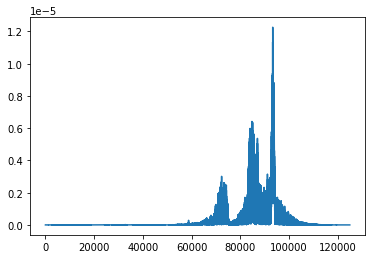

2.414618026412741e-05


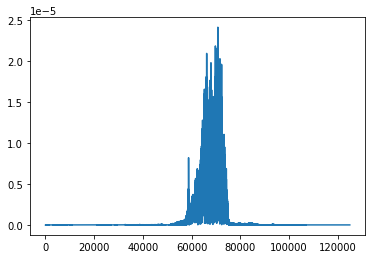

3.2207704059326695e-06


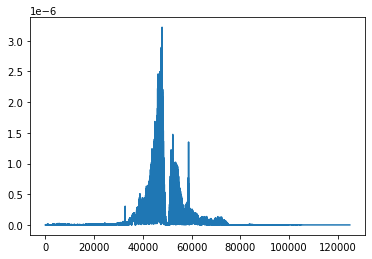

1.4594371481933267e-05


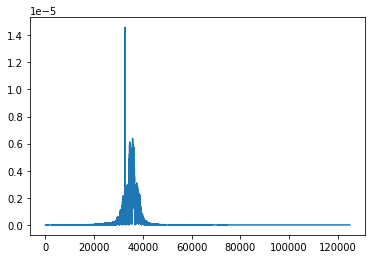

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftshift

# Number of samplepoints
N = len(y[0])
# sample spacing
T = 1.0 / 250000

for i in range(len(y)):
  dataf = fft(y[i])
  xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

  #fig, ax = plt.subplots()
  plt.plot(xf, 2.0/N * np.abs(dataf[:N//2]))
  s = 2.0/N * np.abs(dataf[:N//2])
  print(max(s))
  plt.show()

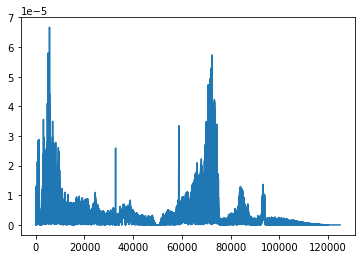

In [ ]:
# Number of samplepoints
N = len(SignalVec[3])
# sample spacing
T = 1.0 / 250000

dataf = fft(SignalVec[3])
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(dataf[:N//2]))
plt.show()